In [ ]:
import numpy as np
import torch
import math
!pip install gpytorch
!pip install adabound
import gpytorch
from gpytorch.kernels.rbf_kernel import postprocess_rbf
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from collections import OrderedDict
import copy
import time
import adabound
from scipy.stats import norm
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [52]:
def scale(X,bounds):
  def func(x,bounds):
    mu = (bounds[:,0]+bounds[:,1])/2
    diff = (bounds[:,1]-bounds[:,0])/2
    new_x = mu+diff*x
    return new_x
  return torch.tensor(np.apply_along_axis(func, 1, X,bounds),dtype = torch.float32)
def function(X,noise=0):
  def func(x):
    # return -math.sin(x[0]*10)
    return -(math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)
  return torch.tensor(np.apply_along_axis(func, 1, X).reshape(-1,1),dtype = torch.float32)
# def function(X,noise=0):
#   # return (-np.sin(3*X[:,0]) - X[:,0]**2 + 0.7*X[:,0] + noise * np.random.randn(*X[:,0].shape)).reshape(-1,1)
#   # return (math.pow((x2-5.1/(4*math.pow(3.14,2))*math.pow(x1,2)+5/3.14*x1-6),2)+10*(1-1/(8*3.14))*math.cos(x1)+10)
#   def func(x):
#     return (math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)
#   return torch.tensor(np.apply_along_axis(func, 1, X).reshape(-1,1),dtype = torch.float32)
D=50
d=3
bounds = np.array([[-5,10],[0,15],[-1,1]])
for i in range(47):
    bounds = np.concatenate((bounds,np.array([[-1,1]])),axis=0)
batch_shape = torch.Size([1])
a1 = torch.linspace(-1, 1, 50)
a2 = torch.linspace(-1, 1, 1)
a3 = torch.linspace(-1,1,1)
train_x = torch.zeros((50,D),dtype=torch.float32).to(device)
ctr=0
mx = -1e30
for i1 in a1:
    for i2 in a2:
        for i3 in a3:
            train_x[ctr,0] = i1
            train_x[ctr,1] = i2
            train_x[ctr,2] = i3
            ctr+=1
train_y = function(scale(train_x,bounds))
mx_x = None
for i in range(len(train_y)):
  if train_y[i]>mx:
    mx = train_y[i]
    mx_x = train_x[i]
 
print(mx,mx_x)
def get_proj_matrix(D,d,hypersphere=0):
  ''' Takes three arguments D : column size, d : row size and hypersphere = 0/1 (if hypersphere is 1 then sample each row of B from S^{D-1} else from N(0,1))
  returns a random B matrix of shape d x D '''
  A = np.random.normal(0,1,(d,D))
  if hypersphere==1:
    for row in range(d):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  return A
 
B = torch.tensor(get_proj_matrix(D,d,1),dtype=torch.float32).to(device)
train_x_d = (train_x @ B.t()).to(device)
train_y = function(scale(train_x,bounds))
train_y = train_y.squeeze(1)
print(train_x.shape)
 
 
 
class AleboKernel(gpytorch.kernels.Kernel):
  ''' creates instances of alebo kernel in which distance metric is mahalonobis instead of euclidean distance.'''
  def __init__(self,B):
    super().__init__(has_length=False,ard_num_dims=None,eps=0.0)
    self.d = B.shape[0]
    self.D = B.shape[1]
    self.B = B
    self.Binv = torch.pinverse(B)
    # self.dtype = B.dtype
    # self.batch_shape = batch_shape
 
    A = torch.qr(torch.randn(self.D,self.D))[0].to(device)
    ABinv = A[:self.d,:] @ self.Binv
    T = ABinv.t() @ ABinv
    U = torch.cholesky(T,upper = True)
    self.idx = U.nonzero().t().tolist()
    Uvec = U[self.idx]#.repeat(*batch_shape,1)
    # print(Uvec)
    t = torch.tensor(2.0)
    self.register_parameter(name = "Uvec",parameter=torch.nn.Parameter(Uvec))
 
 
    
  def forward(self,x1,x2,**params):
    U_t = torch.zeros(self.Uvec.shape[:-1]+torch.Size([self.d,self.d])).to(device)
    U_t[...,self.idx[1],self.idx[0]] = self.Uvec
    z1 = x1 @ U_t
    z2 = x2 @ U_t
    return self.covar_dist(z1,z2,square_dist=True,dist_postprocess_func=postprocess_rbf,postprocess=True,**params)
 
class AleboGP(gpytorch.models.ExactGP):
  ''' Creates instance of Alebo GP by taking into account the mahalonobis kernel '''
  def __init__(self, train_x, train_y, likelihood,B):
    super().__init__(train_x, train_y, likelihood)
    self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=AleboKernel(B=B))
    self.mean_module = gpytorch.means.ConstantMean()
  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

tensor([-5.1227]) tensor([ 0.1429, -1.0000, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])
torch.Size([50, 50])


In [53]:
 
def calc_grad(model,likelihood,train_x,train_y):
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=.01)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
 
  optimizer.zero_grad()
  output = model(train_x)
  loss = -mll(output, train_y).sum()
  loss.backward()
  optimizer.step()
  
  model.eval()
  likelihood.eval()
  return model.covar_module.base_kernel.Uvec.grad
 
 
def train(model,likelihood,train_x,train_y,training_iter=20000):
  ''' Takes model and training data and return the optimised parameter of the AleboGP model'''
# training_iter = 50
  model.to(device)
  likelihood.to(device)
  train_x = train_x.to(device)
  train_y = train_y.to(device)
  model.train()
  likelihood.train()
  # print(model.parameters())
  # for params in model.parameters():
  #   print(params)
  # optimizer = adabound.AdaBound(model.parameters(), lr=2,final_lr = 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=.01) 
 
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
 
  loss = 1000
  prevloss = 1200
  cnt = 0 
  for i in range(training_iter):
      # print(i)
  # while abs((prevloss-loss)/prevloss)>0.000001:
      cnt+=1
      if cnt%10000==0:
        
        print(loss,time.time()-st)
      # print(cnt)
      optimizer.zero_grad()
      output = model(train_x)
      prevloss = loss 
      loss = -mll(output, train_y).sum()
      loss.backward()
 
      optimizer.step()
      params_dict = OrderedDict(mll.named_parameters())
      # print(loss,prevloss)
      # print(params_dict)
      # print(model.covar_module.base_kernel.)
      # if i in [0,1]:
        # for param_name, attr in params_dict.items():
        #   print(param_name)
        #   print(params_dict[param_name])
        # print(params_dict[param_name].requires_grad)
 
  
  model.eval()
  likelihood.eval()
 
  return model,likelihood
# st = time.time()
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = AleboGP(train_x_d, train_y, likelihood,B)
 
# model,likelihood = train(model,likelihood,train_x_d,train_y)
# print(time.time()-st)

In [54]:
def get_r2_square(model,likelihood,train_x,train_y):
  ''' takes mode and training data and calculates r2 square score for of the model on the data'''
  observed_pred = likelihood(model(train_x))
  lower,upper = observed_pred.confidence_region()
  r2_square = 0
  sum_diff = 0
  for i in range(train_x.shape[0]):
    r2_square += (observed_pred.mean[i].detach().numpy()-train_y[i].numpy())**2
  sum_diff += np.sum(upper.detach().numpy())-np.sum(lower.detach().numpy())
 
  return r2_square,sum_diff
    
def get_best_fit_gp(train_x,train_y,iter = 20000,n_trials=2):
  ''' generates and train n_trials number of models and return the model that fits the data in the best way by using r2 square metric. '''
  ## Use MLL if it gives poor result.
  # best_state = {}
  best_i = None
  r2_square = 1e35
  models = []
  likelihoods = []
  for i in range(n_trials):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = AleboGP(train_x, train_y, likelihood,B)
 
    model,likelihood = train(model,likelihood,train_x,train_y,iter)
    models.append(model)
    likelihoods.append(likelihood)
    r2_square_i,sum_diff_i = get_r2_square(model,likelihood,train_x,train_y)
    # print(r2_square_i)
    if r2_square_i < r2_square:
      # best_state = model.state_dict()
      best_i = i
      r2_square = r2_square_i
  
  # best_likelihood =gpytorch.likelihoods.GaussianLikelihood()
  # best_model = AleboGP(train_x, train_y, likelihood,B)
  # best_model.state_dict(best_state)
 
  return likelihoods[best_i],models[best_i]
 
 
# def sample_U(likelihood,model,nsamp=10):
  # return list of Uvec for each model
# print(train_x@B.t().shape,train_y)
# likelihood, model = get_best_fit_gp(train_x @ B.t(),train_y)
# print(model.covar_module.base_kernel.Uvec.grad)

In [ ]:
model.eval()
likelihood.eval()
 
z = torch.linspace(-1,1,100)
t = torch.zeros((100,3))
t[:,0] = z.t()
t[:,1] = -1
t[:,2] = -1
# print(train_x,t)
observed_pred = likelihood(model(t@B.t()))
lower,upper = observed_pred.confidence_region()
 
# w,_ = get_final_pred(m_list,l_list,t@B.t())
plt.plot((train_x.numpy())[:,0],train_y,'bo')
plt.plot(t[:,0],observed_pred.mean.detach().numpy())
plt.show()
 
plt.plot(train_y, likelihood(model(train_x@B.t())).mean.detach().numpy(),'bo' ,label="Pred")
plt.plot(train_y,train_y,label='Ideal')
plt.legend()

In [55]:
def double_derivative(i,epsilon_i,m1,m2,l1,l2,train_x,train_y):
    '''Function which takes the models m1 and m2 (m2 is for m1+epsilon)
        and returns the double derivative for i-th component'''
    # print(m1.covar_module.base_kernel.Uvec)
    g1 = (m1.covar_module.base_kernel.Uvec.grad)
    g2 = calc_grad(m2,l2,train_x,train_y)
    # print(g1,g2)
    return (g2[i] - g1[i])/epsilon_i
 
 
def print_param(model):
  print()
  for x in model.named_parameters():
      print(x)
  print()
 
def update_Uvec(model,likelihood,i,ep):
  ''' updates the ith element of Uvec model parameter from Uvec[i] to Uvec[i]+ep and returns the model with updated parameters'''
  model_copy = copy.deepcopy(model)
  # print_param(model_copy)
  Uvec = model_copy.covar_module.base_kernel.Uvec
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(False)
  Uvec[i] = Uvec[i]+ep
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(True)
  # print_param(model_copy)
 
  return model_copy,likelihood
 
 
def sample_U(model,likelihood,train_x,train_y,n=1):
  '''Takes best fit model and return n model where each model's Uvec is sampled from laplace approx of MAP model(model,likelihood)'''
  Uvec = model.covar_module.base_kernel.Uvec
  mean_constant = model.mean_module.constant
  output_scale = model.covar_module.raw_outputscale
  noise_covar = model.likelihood.noise_covar.raw_noise
 
  hessian = np.zeros((Uvec.shape[0],Uvec.shape[0]))
  ep = 1e-3 * np.abs(Uvec.detach().numpy()) + 1e-4
  for j in range(Uvec.shape[0]):
    m2,l2 = update_Uvec(model,likelihood,j,ep[j])
    hessian[j,j] = double_derivative(j,ep[j],model,m2,likelihood,l2,train_x,train_y)
  
  # print(hessian)
  Sigma = np.linalg.inv(-hessian)
  samples = np.random.multivariate_normal(mean=Uvec.detach().numpy(), cov=Sigma, size=(n - 1))
  
 
  m_list = [model]
  l_list = [likelihood]
 
  for i in range(n-1):
    new_model = copy.deepcopy(model)
    new_likelihood = copy.deepcopy(likelihood)
    new_model.train()
    
 
    new_Uvec = torch.tensor(samples[i])
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)
    new_model.covar_module.base_kernel.Uvec.copy_(new_Uvec)
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)
 
    new_model.eval()
    new_model,new_likelihood = train(new_model,new_likelihood,train_x,train_y)
 
    m_list.append(new_model)
    l_list.append(new_likelihood)
 
  
  return m_list,l_list
 
# m_list,l_list = sample_U(model,likelihood,train_x @ B.t(),train_y)
# update_Uvec(model,likelihood,0,torch.tensor(1))

In [56]:
def get_final_pred(models,likelihoods,test_x): # test_x is in n*d dimensions.returns means,variances
    preds = [likelihood(model(test_x)) for likelihood,model in zip(likelihoods,models)]
    means = torch.tensor([[y.mean for y in x] for x in preds]).t()
    variances = torch.tensor([[y.variance for y in x] for x in preds]).t()
    mu = torch.mean(means,axis=1)
    variance = torch.mean(variances,axis=1) + torch.var(means,axis=1,unbiased=False)
    return mu,variance
 
# model.eval()
# likelihood.eval()
 
# observed_pred = likelihood(model(train_x @ B.t()))
# lower,upper = observed_pred.confidence_region()
# y_pred,_ = get_final_pred(m_list,l_list,train_x_d)
# plt.plot(train_y, y_pred,'bo' ,label="Pred")
# plt.plot(train_y,train_y,label='Ideal')
# plt.legend()

In [57]:
 
def acq_func(X,y_t,e,models,likelihoods):
  # print(X_t.shape,type(X_t))
  X= np.expand_dims(X,axis=0)
  # print(X.shape,type(X))
  y,std = get_final_pred(models,likelihoods,torch.tensor(X,dtype = torch.float32))
  std = std.numpy()
  std = std.reshape(-1,1)
  best_y = np.max(y_t.numpy())
  
  a = (y.numpy()-best_y-e)
  ei = a*norm.cdf(a/std) + std*norm.pdf(a/std)
  ei[std==0] = 0
#   print("acq called with x_d={},y_pred={},ei={}".format(X,y.numpy(),ei))
  return ei
#   return y.numpy()
#   a = (y.numpy() - best_y)
#   pi = norm.cdf(a/(std+1e-9))
#   return pi
def gen(n,d,B):
  results=np.array([])
  D = B.shape[1]
  B_inv=np.linalg.pinv(B)
  while len(results)<n:
    x=(np.random.rand(D,1)*2-1)
    # x = scale(x,bounds)
    # print(B_inv@x,bounds[:,1])
    if ((B_inv@(B.numpy()@x)).T<=1).sum()== D and ((B_inv@(B.numpy()@x)).T>=-1).sum() == D:
      # print("yes")
      if results.size==-0:
        results = (B.numpy()@x).T
      else:
        results = np.concatenate((results,(B.numpy()@x).T),axis=0)
  return results
 
 
def constrained_minimize(objective,Binv,x0):
    # def constraint_generator_minus_1(Binv,i):
    #     def con(x):
    #         # print(x)
    #         x_D = Binv @ x
    #         return x_D[i]+1
    #     return con
    # def constraint_generator_plus_1(Binv,i):
    #     def con(x):
    #         x_D = Binv @ x
    #         return 1-x_D[i]
    #     return con
    # constraints_fun = []
    # for i in range(B.shape[0]):
    #     constraints_fun.append(constraint_generator_minus_1(Binv,i))
    #     constraints_fun.append(constraint_generator_plus_1(Binv,i))
    # constraints = [{'type':'ineq', 'fun':fun} for fun in constraints_fun]
    constraints = [LinearConstraint(Binv,-np.ones(D),np.ones(D))]
    options={'eps': 1e-3,}
    candidate = minimize(objective,x0,constraints=constraints,method='SLSQP',options=options)
    return candidate
          
def next_best_point(X_t,models,likelihoods,e,trials,acq_func,B):
  min_val = 1e18
  min_x = None
  y_t,_ = get_final_pred(models,likelihoods,X_t)

  def min_obj(x):
    return -acq_func(x,y_t,e,models,likelihoods)
  random_starts = gen(trials,B.shape[0],B)
  for st in random_starts:
    # print(np.expand_dims(st, axis=0))
    # print("Random start:",st)
    candidate = constrained_minimize(min_obj,np.linalg.pinv(B),st)
    if candidate.fun < min_val:
      min_val = candidate.fun
      min_x = candidate.x
  return torch.tensor(np.expand_dims(min_x,axis=0),dtype=torch.float32)
 
 
 
 
# def objective(x):
#     # print("x=",x)
#     return x.sum()
# B = np.eye(3)
# x0 = np.array([0.5,0.5,0.5])
# constrained_minimize(objective,B,x0,bounds)

**Combined Alebo code**

In [60]:
D=50
d=3
st = time.time()


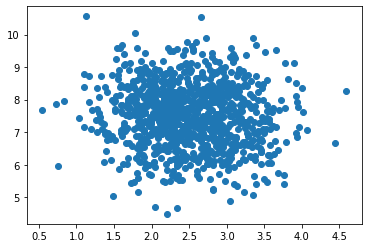

In [145]:
B = torch.tensor(get_proj_matrix(D,d,1),dtype=torch.float32)
x_temp = gen(1000,d,B)
B_inv=np.linalg.pinv(B)
x_temp_D = scale(x_temp@B_inv.T,bounds)
plt.scatter(x_temp_D[:,0],x_temp_D[:,1])
plt.show()


In [146]:
x_t = torch.tensor(gen(5,d,B),dtype=torch.float32)
y_t = function(scale(x_t@B_inv.T,bounds))
y_t = y_t.squeeze(1)
print(x_t,y_t)
for i in range(40):
  ## Git model
  print("Iteration no. is: ",i)
  likelihood, model = get_best_fit_gp(x_t,y_t)
  m_list,l_list = sample_U(model,likelihood,x_t,y_t)
  
  # z = torch.linspace(-1,1,100)
  # t = torch.zeros((100,3))
  # t[:,0] = z.t()
  # w,_ = get_final_pred(m_list,l_list,t@B.t())
  # plt.plot((x_t.numpy()@B_inv.T)[:,0],y_t,'bo')
  # plt.plot(t[:,0],w.numpy())
  # plt.show()
  x_next = next_best_point(x_t,m_list,l_list,-0.1,15,acq_func,B)
  y_next = function(scale(x_next@B_inv.T,bounds))
  y_next = y_next.squeeze(1)
  print(x_next,scale((B_inv@(x_next.numpy().T)).T,bounds).T,y_next)
  # print(x_next,y_next)
  x_t = torch.cat((x_t,x_next),axis=0)
  y_t = torch.cat((y_t,y_next),axis=0)
  
  print("Time taken : ",time.time()-st)
 
print(time.time()-st)

tensor([[-0.7956, -0.6454, -0.0650],
        [-0.4933, -0.2171,  0.3417],
        [-0.3634,  0.0684,  0.0974],
        [ 1.3452,  0.3834,  0.1908],
        [-0.2796,  0.4082,  0.0610]]) tensor([-34.0878, -24.5463, -21.7462, -25.7892, -17.5949])
Iteration no. is:  0
tensor(3.0099, grad_fn=<NegBackward>) 436.0083963871002
tensor(2.2634, grad_fn=<NegBackward>) 465.98837208747864


/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


tensor(3.0069, grad_fn=<NegBackward>) 496.2756242752075
tensor(2.1584, grad_fn=<NegBackward>) 526.5771729946136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: covariance is not positive-semidefinite.


tensor([[-1.6111,  1.2798,  1.8717]]) tensor([[ 3.0518],
        [ 3.9925],
        [-0.2100],
        [ 0.6490],
        [-0.8115],
        [-0.3675],
        [-0.4062],
        [-0.2916],
        [ 0.3010],
        [-0.4068],
        [-0.6164],
        [ 0.1026],
        [-0.0082],
        [ 0.7385],
        [-0.2434],
        [ 0.3073],
        [ 0.2676],
        [ 0.0667],
        [ 0.1823],
        [ 0.3085],
        [-0.0195],
        [-0.5457],
        [-0.5498],
        [-0.4348],
        [-0.4376],
        [ 0.0772],
        [ 0.7154],
        [ 0.1196],
        [ 0.1583],
        [-0.1510],
        [-0.3539],
        [ 0.2317],
        [ 0.2379],
        [ 0.2233],
        [ 0.0633],
        [ 0.4422],
        [ 0.0834],
        [-0.3671],
        [-0.5278],
        [ 0.5185],
        [-0.4238],
        [-0.3239],
        [-0.3744],
        [ 0.2538],
        [-0.0048],
        [-0.6285],
        [-0.4967],
        [ 0.3580],
        [-0.0476],
        [-0.1868]]) tensor([-3.

In [ ]:
for i in range(70,80):
  ## Git model
  print("Iteration no. is: ",i)
  likelihood, model = get_best_fit_gp(x_t,y_t)
  m_list,l_list = sample_U(model,likelihood,x_t,y_t)
  # z = torch.linspace(-1,1,100)
  # t = torch.zeros((100,3))
  # t[:,0] = z.t()
  # w,_ = get_final_pred(m_list,l_list,t@B.t())
  # plt.plot((x_t.numpy()@B_inv.T)[:,0],y_t,'bo')
  # plt.plot(t[:,0],w.numpy())
  # plt.show()
  x_next = next_best_point(x_t,m_list,l_list,0,15,acq_func,B)
  y_next = function(scale(x_next@B_inv.T,bounds))
  y_next = y_next.squeeze(1)
  print(x_next,scale((B_inv@(x_next.numpy().T)).T,bounds).T,y_next)
  # print(x_next,y_next)
  x_t = torch.cat((x_t,x_next),axis=0)
  y_t = torch.cat((y_t,y_next),axis=0)
  
  print("Time taken : ",time.time()-st)

# TESTING CODE

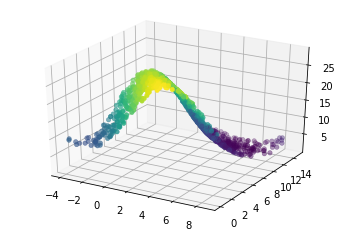

In [ ]:

x_temp = gen(1000,d,B)
x_temp_D = scale(x_temp@B_inv.T,bounds)
y_temp = [acq_func(x1,y_t,0,m_list,l_list)[0][0] for x1 in x_temp]

ax = plt.axes(projection='3d')
ax.scatter(x_temp_D[:,0], x_temp_D[:,1], y_temp, c=y_temp, cmap='viridis', linewidth=0.5);

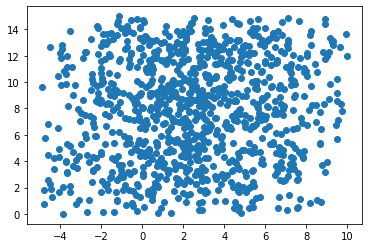

In [51]:
B = torch.tensor(get_proj_matrix(D,d,1),dtype=torch.float32)
x_temp = gen(1000,d,B)
B_inv=np.linalg.pinv(B)
x_temp_D = scale(x_temp@B_inv.T,bounds)
plt.scatter(x_temp_D[:,0],x_temp_D[:,1])
plt.show()

[tensor(33.6978), tensor(24.1563), tensor(21.3562), tensor(21.3562), tensor(17.2049), tensor(2.7617), tensor(2.7617), tensor(2.7617), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546), tensor(0.1546)]


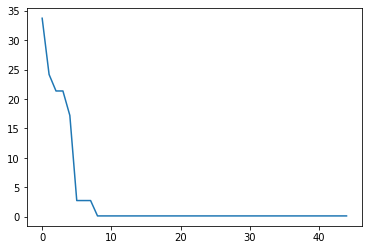

In [152]:
dp = []
optimality_gap = 1e35
for i in y_t:
  if optimality_gap>abs(-0.39-i):
    optimality_gap = abs(-0.39-i)
  dp.append(optimality_gap)
print(dp)
plt.plot(range(y_t.shape[0]),dp)
plt.show()

tensor([ 2.9673,  2.3807, -0.0437,  0.5755, -0.5865, -0.8340,  0.0205, -0.5208,
        -0.0220, -0.3078,  0.1986,  0.3277, -0.7950,  1.0000, -0.9393,  0.3407,
         0.0503, -0.2767, -0.1930,  1.0000, -0.3336, -0.5416, -0.6674, -0.9150,
         0.5281, -0.4472,  0.5685, -0.1354, -0.1563, -0.4989, -0.0330,  0.5209,
        -0.0785, -0.0814, -0.3021,  0.4357,  0.2750, -0.9345,  0.1997, -0.9857,
         0.5714, -1.0000, -0.0521, -0.5554,  0.0198,  0.2071,  0.4912,  0.1308,
         0.0586,  0.2101]) tensor([-0.5386,  3.2877, -0.6777]) tensor(-0.5446) tensor(8)
[tensor(-0.5446), tensor(-1.4529), tensor(-2.4295), tensor(-3.1517), tensor(-3.6052), tensor(-3.6052), tensor(-3.6193), tensor(-3.7461), tensor(-5.0027), tensor(-7.6184), tensor(-13.9927), tensor(-14.4372), tensor(-15.8897), tensor(-15.9211), tensor(-16.1831), tensor(-16.4202), tensor(-17.3560), tensor(-17.5949), tensor(-18.5260), tensor(-18.8263), tensor(-20.7622), tensor(-21.5865), tensor(-21.6082), tensor(-21.7462), tensor(-

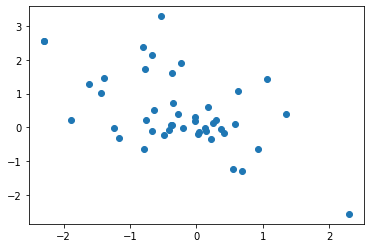

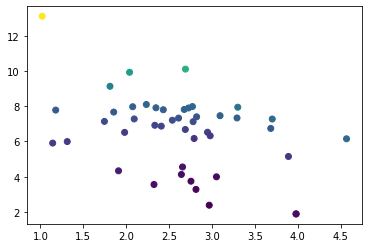

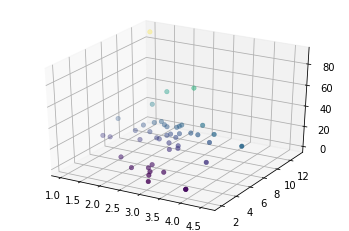

In [151]:

x_t_D = scale(x_t@B_inv.T,bounds)
best_idx = torch.argmax(y_t)
print(x_t_D[best_idx],x_t[best_idx],y_t[best_idx],best_idx)
print(sorted(y_t)[::-1])
# for i in range(205):
    # print(i,x_t_D[i],y_t[i])
plt.scatter(x_t[:,0], x_t[:,1])
plt.show()
plt.scatter(x_t_D[:,0],x_t_D[:,1],c=-y_t)
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(x_t_D[:,0], x_t_D[:,1], -y_t, c=-y_t, cmap='viridis', linewidth=0.5)

In [159]:
import json
def toList(x):
    return x.numpy().tolist()
save_obj = {
    "d": d,
    "D": D,
    "B": toList(B),
    "x_t": toList(x_t),
    "y_t": toList(y_t)
}
with open("branin_{}_{}.txt".format(d,D), "w") as fp:
    json.dump(save_obj,fp)


In [ ]:
scale(torch.tensor(gen(10,2,B)@B_inv.T,dtype=torch.float32),bounds)

In [ ]:
random_starts = gen(10,B.shape[0],B)
for st in random_starts:
  # print(st.T)
  candidate = constrained_minimize(objective,np.linalg.pinv(np.eye(2)),x0=st,bounds)
  print(scale(B_inv@st,bounds),st,candidate.x)

In [ ]:
z = torch.linspace(-1,1,100)
t = torch.zeros((100,3))
t[:,0] = z.t()